# SARS-CoV-2 RBD `phydms` analysis

This notebook contains my first pass analysis using `phydms` to compare Tyler and Allie's RBD DMS to natural SARS-CoV evolution. 

### sequences
The raw sequences come from the [SARS-CoV-2 RBD DMS repo](https://raw.githubusercontent.com/jbloomlab/SARS-CoV-2-RBD_DMS/master/data/alignments/RBDs_nt_aligned.fasta). I need to double check with Tyler but I believe it contains all of the sequences described in the README:
> - The curated set of 30 sequences from Letko, Marzi, and Munster (2020), which contained all known unique RBD sequences at the time of its publication. See Extended Data Fig 1 for more information.
- Bat sarbecovirus isolate WIV16, which was removed from the Letko dataset because it has an identical RBD amino acid sequence to WIV1, and isolate HKU3-1, which was removed from the Letko dataset because it has an identical RBD amino acid sequence to HKU3-13.
- RaTG13 and RmYN02, two newly described bat CoV sequences that are the most closely related strains currently known to SARS-CoV-2 (at least at the whole-genome level).
- Two recent pangolin CoV sequences from Lam et al. (2020), including the infectious virus isolated from a pangolin seized in Guanxi, and the consensus sequence from two closely related isolates from pangolins seized in Guangdong. The consensus sequence was constructed from an alignment of the GD pangolin CoV in GISAID accssion EPI_ISL_410544, and the reconstructed metagenomic viral genome reported in the Lam et al. (2020) supplement.
- BtKY72, a bat coronavirus isolated in Kenya which, along with the Bulgaria sample BM48-31 is used to root the phylogeny

### dms measurements
The raw measurements come from the [single mutant effects csv](https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS/master/results/single_mut_effects/single_mut_effects.csv
). To convert these into preferences I copied over Jesse's code from the [logoplots notebook](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS/blob/master/logoplots_of_muteffects.ipynb).

## notebook setup

In [1]:
import pandas as pd
import math
import numpy
from phydmslib.utils import modelComparisonDataFrame
from ete3 import PhyloTree, TreeStyle, NodeStyle
from utils.utils import create_nodestyle, viztree, omegabysiteresults, relresults

In [2]:
rerun = False

## `phydms_prepalignment`

I ran `phydms_prepalignment` twice: 
- Once with the default parameters. This filtered the original 37 sequences down to 11. Most of the sequences were filtered out in the step that maintains only sequences which have >= 0.7 identity to the focal sequence.
- To get a larger alignment, I filtered out only sequences with < 0.5 identity to the focal sequence. This `phydms_prepalignment` run kept 29 of the original 37 sequences

In [3]:
if rerun:
    !mkdir results/
else:
    print('no re-run')

no re-run


In [4]:
if rerun:
    !phydms_prepalignment data/RBD.fasta results/RBD.fasta SARS-CoV-2_MN908947 
else:
    print('no re-run')

no re-run


In [5]:
if rerun:
    !phydms_prepalignment data/RBD.fasta results/RBD_min0.5.fasta SARS-CoV-2_MN908947 --minidentity 0.5
else:
    print('no re-run')

no re-run


## format preferences

Here is where I just took code from Jesse's notebook and calculated the "probabilities" for expression and for binding.

In [6]:
mut_effects = pd.read_csv('data/single_mut_effects.csv')
# binding = df.drop(columns='expr_avg').pivot(index='site', columns='mutant', values='bind_avg').drop(columns='*')
# binding.tail()

In [7]:
# this section is from Jesse's notebook
conditions = ['bind', 'expr']
# get mutation effects without stop codons
nostop_mut_effects = mut_effects.query('(mutant != "*") and (wildtype != "*")')

# exponent scaling factors alpha for binding and expression
manual_scale_alpha = 1.4  # ad hoc additional scaling factor for exponents
alpha_bind = math.log(10) * manual_scale_alpha
alpha_expr = alpha_bind * ((nostop_mut_effects['expr_avg'].max() - nostop_mut_effects['expr_avg'].min()) /
                           (nostop_mut_effects['bind_avg'].max() - nostop_mut_effects['bind_avg'].min()))
print(f"alpha (exponent scale factor):\nbinding = {alpha_bind:.3f}\nexpression = {alpha_expr:.3f}")

def compute_site_info(p):
    p = p[p > 0]
    assert len(p), 'no non-zero values'
    return math.log(20) + sum(p * numpy.log(p))

df = (
    nostop_mut_effects
    .assign(nonorm_prob_bind=lambda x: numpy.exp(alpha_bind * x['bind_avg']).fillna(0),
            nonorm_prob_expr=lambda x: numpy.exp(alpha_expr * x['expr_avg']).fillna(0),
            sitesum_prob_bind=lambda x: x.groupby('site_RBD')['nonorm_prob_bind'].transform('sum'),
            sitesum_prob_expr=lambda x: x.groupby('site_RBD')['nonorm_prob_expr'].transform('sum'),
            prob_bind=lambda x: x['nonorm_prob_bind'] / x['sitesum_prob_bind'],
            prob_expr=lambda x: x['nonorm_prob_expr'] / x['sitesum_prob_expr']
            )
    [['site_SARS2', 'site_RBD', 'wildtype', 'mutant',
      'prob_bind', 'prob_expr', 'bind_avg', 'expr_avg']]
    ).rename(columns={'site_RBD': 'site'})

assert not df[['prob_bind', 'prob_expr']].isnull().any(axis=None)

df.head().round(3)

alpha (exponent scale factor):
binding = 3.224
expression = 3.173


,site_SARS2,site,wildtype,mutant,prob_bind,prob_expr,bind_avg,expr_avg
0,331,1,N,A,0.050,0.124,-0.03,-0.11
1,331,1,N,C,0.041,0.003,-0.09,-1.26
2,331,1,N,D,0.061,0.044,0.03,-0.44
3,331,1,N,E,0.055,0.066,0.00,-0.31
4,331,1,N,F,0.040,0.019,-0.10,-0.70


In [8]:
for condition in conditions:
    temp = df.pivot(index='site', columns='mutant', values=f'prob_{condition}')
    assert numpy.allclose(temp.sum(axis=1), 1, atol=0.005)
    temp.reset_index().to_csv(f'results/{condition}.csv', index=False)

## run `phydms` comprehensive

I ran `phydms_comprehensive` on both the "small" and "large" alignments

In [9]:
if rerun:
    !phydms_comprehensive phydms_comprehensive/ results/RBD.fasta results/bind.csv results/expr.csv --raxml raxmlHPC --gammaomega --omegabysite --omega_random_effects_likelihood --ncpus 2
else:
    print('no re-run')

no re-run


In [10]:
if rerun:
    !phydms_comprehensive phydms_comprehensive_0.5/ results/RBD_min0.5.fasta results/bind.csv results/expr.csv --raxml raxmlHPC --gammaomega --omegabysite --omega_random_effects_likelihood --ncpus 2
else:
    print('no re-run')

no re-run


## results

In [11]:
# for the positive selection analysis
sig_cutoff = 0.05
expcm_models = ["ExpCM_expr_gammaomega", "ExpCM_expr", "ExpCM_bind_gammaomega", "ExpCM_bind"]

## "small" alignment (>= 0.7 identity to the focal sequence)

### model comparison

These results are not totally surprising. Both binding and expression ExpCMs outperform the YNGKP_M5. The gammaomega ExpCMs outperform the single-omega-value ExpCMs. I would point out that the deltaAIC among the ExpCMs might not really be that significant.

In [12]:
df = modelComparisonDataFrame("phydms_comprehensive/modelcomparison.md", True)
df

,Model,deltaAIC,LogLikelihood,nParams,alpha_omega,beta,beta_omega,kappa,omega
0,ExpCM_expr_gammaomega,0.00,-2524.39,7,0.37,1.58,0.85,2.31,NaN
1,ExpCM_expr,138.08,-2594.43,6,NaN,1.49,NaN,1.76,0.23
2,ExpCM_bind_gammaomega,235.62,-2642.20,7,0.33,1.78,0.98,2.16,NaN
3,ExpCM_bind,369.86,-2710.32,6,NaN,2.03,NaN,1.78,0.19
4,YNGKP_M5,796.22,-2917.50,12,0.30,NaN,2.91,1.77,NaN
5,averaged_ExpCM_expr_gammaomega,824.60,-2936.69,7,0.30,1.16,2.07,1.91,NaN
6,averaged_ExpCM_bind_gammaomega,834.88,-2941.83,7,0.30,0.00,2.00,1.94,NaN
7,averaged_ExpCM_expr,1011.40,-3031.09,6,NaN,1.60,NaN,1.78,0.10
8,YNGKP_M0,1020.20,-3030.49,11,NaN,NaN,NaN,1.63,0.06
9,averaged_ExpCM_bind,1030.98,-3040.88,6,NaN,0.00,NaN,1.81,0.10


## omegabysite

In [13]:
omegabysiteresults(expcm_models, "phydms_comprehensive", sig_cutoff)

Model ExpCM_expr_gammaomega
There are 0 sites with sig (Q < 0.05) evidence for omega > 1.
There are 11 sites with sig (Q < 0.05) evidence for omega < 1.
    site  omega         P    dLnL        Q
0     78  0.000  0.000006  10.217  0.00124
1    145  0.021  0.000399   6.268  0.01790
2     59  0.000  0.000446   6.165  0.01790
3    174  0.000  0.000406   6.253  0.01790
4    166  0.000  0.000244   6.730  0.01790
5    192  0.000  0.000734   5.701  0.02110
6    159  0.000  0.000696   5.750  0.02110
7    178  0.000  0.000854   5.560  0.02150
8    194  0.000  0.001260   5.204  0.02800
9     37  0.000  0.001440   5.075  0.02900
10   172  0.000  0.001800   4.874  0.03280

Model ExpCM_expr
There are 0 sites with sig (Q < 0.05) evidence for omega > 1.
There are 10 sites with sig (Q < 0.05) evidence for omega < 1.
   site  omega         P   dLnL        Q
0    78  0.000  0.000010  9.796  0.00193
1    59  0.000  0.000354  6.380  0.02440
2   166  0.000  0.000363  6.356  0.02440
3   159  0.000  0.000572

### REL 

In [14]:
relresults(expcm_models, "phydms_comprehensive", sig_cutoff)

Model ExpCM_expr_gammaomega
There are 0 sites with sig (fdr < 0.05) evidence for omega > 1.

Model ExpCM_bind_gammaomega
There are 0 sites with sig (fdr < 0.05) evidence for omega > 1.



## "large" alignment (>= 0.5 identity to the focal sequence)

### model comparison
These results are not totally surprising. Both binding and expression ExpCMs outperform the YNGKP_M5. The gammaomega ExpCMs outperform the single-omega-value ExpCMs. The deltaAIC within the ExpCMs are larger for this larger alignment.

In [15]:
df = modelComparisonDataFrame("phydms_comprehensive_0.5/modelcomparison.md", True)
df

,Model,deltaAIC,LogLikelihood,nParams,alpha_omega,beta,beta_omega,kappa,omega
0,ExpCM_expr_gammaomega,0.00,-5798.16,7,0.48,1.33,2.02,2.37,NaN
1,ExpCM_expr,279.20,-5938.76,6,NaN,1.28,NaN,2.20,0.15
2,ExpCM_bind_gammaomega,385.14,-5990.73,7,0.38,1.17,2.42,2.32,NaN
3,ExpCM_bind,717.22,-6157.77,6,NaN,1.30,NaN,2.18,0.12
4,averaged_ExpCM_expr_gammaomega,883.10,-6239.71,7,0.32,1.32,3.01,2.25,NaN
5,YNGKP_M5,896.24,-6241.28,12,0.30,NaN,4.25,2.07,NaN
6,averaged_ExpCM_bind_gammaomega,900.72,-6248.52,7,0.32,0.00,2.98,2.28,NaN
7,averaged_ExpCM_expr,1315.32,-6456.82,6,NaN,1.56,NaN,2.17,0.07
8,averaged_ExpCM_bind,1340.90,-6469.61,6,NaN,0.00,NaN,2.20,0.07
9,YNGKP_M0,1371.08,-6479.70,11,NaN,NaN,NaN,2.01,0.04


### omegabysite

In [16]:
omegabysiteresults(expcm_models, "phydms_comprehensive_0.5", 0.05)

Model ExpCM_expr_gammaomega
There are 0 sites with sig (Q < 0.05) evidence for omega > 1.
There are 81 sites with sig (Q < 0.05) evidence for omega < 1.
    site  omega             P    dLnL             Q
0     78  0.000  2.530000e-10  20.003  5.090000e-08
1    192  0.000  1.310000e-09  18.400  1.320000e-07
2    199  0.025  5.760000e-09  16.957  3.860000e-07
3    188  0.000  6.150000e-08  14.657  3.090000e-06
4    109  0.029  4.940000e-07  12.644  1.840000e-05
..   ...    ...           ...     ...           ...
76    41  0.000  1.620000e-02   2.889  4.150000e-02
77    45  0.000  1.600000e-02   2.901  4.150000e-02
78   114  0.196  1.630000e-02   2.885  4.150000e-02
79   164  0.186  1.840000e-02   2.778  4.630000e-02
80    40  0.000  1.880000e-02   2.759  4.670000e-02

[81 rows x 5 columns]

Model ExpCM_expr
There are 0 sites with sig (Q < 0.05) evidence for omega > 1.
There are 76 sites with sig (Q < 0.05) evidence for omega < 1.
    site  omega             P    dLnL             Q
0    

## REL

In [17]:
relresults(expcm_models, "phydms_comprehensive_0.5", sig_cutoff)

Model ExpCM_expr_gammaomega
There are 0 sites with sig (fdr < 0.05) evidence for omega > 1.

Model ExpCM_bind_gammaomega
There are 0 sites with sig (fdr < 0.05) evidence for omega > 1.



## visualizing the tree

In [18]:
clade_dictionary = {"Bat-SARS-related-CoV(SE Asia)": (["HuB2013_KJ473814", "ZXC21_MG772934"], "SandyBrown"),
                    "Bat-SARS-related-CoV(non Asian)": (["BtKY72_KY352407", "BM48-31_NC014470"], "Pink"),
                    "SARS-CoV-1 Clade": (["LYRa11_KF569996", "RsSHC014_KC881005"], "MediumSeaGreen"),
                    "SARS-CoV-2 Clade": (["RaTG13_MN996532", "SARS-CoV-2_MN908947"], "LightSteelBlue")}

### small alignment (> 0.7 to focal sequence)

SandyBrown Bat-SARS-related-CoV(SE Asia)
Pink Bat-SARS-related-CoV(non Asian)
MediumSeaGreen SARS-CoV-1 Clade
LightSteelBlue SARS-CoV-2 Clade


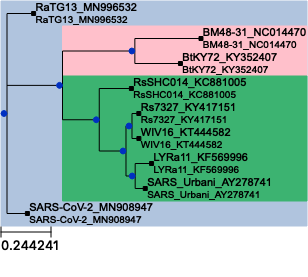

In [19]:
t = viztree("phydms_comprehensive/RAxML_tree.newick", clade_dictionary)
for key in clade_dictionary:
    print(clade_dictionary[key][1], key)
t.render("%%inline", tree_style=TreeStyle())

### large alignment (> 0.5 to focal sequence)

SandyBrown Bat-SARS-related-CoV(SE Asia)
Pink Bat-SARS-related-CoV(non Asian)
MediumSeaGreen SARS-CoV-1 Clade
LightSteelBlue SARS-CoV-2 Clade


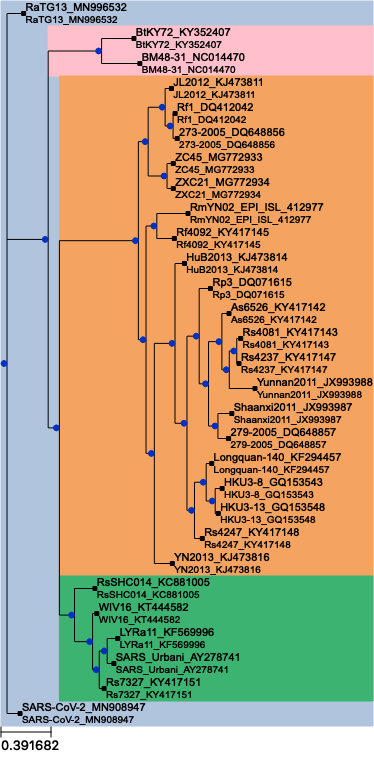

In [20]:
t = viztree("phydms_comprehensive_0.5/RAxML_tree.newick", clade_dictionary)
for key in clade_dictionary:
    print(clade_dictionary[key][1], key)
t.render("%%inline", tree_style=TreeStyle())